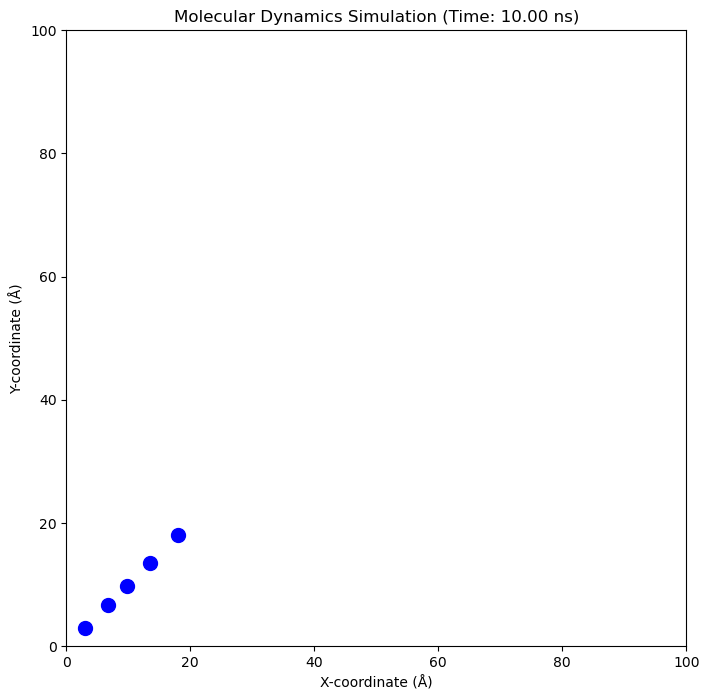

In [6]:
""" Molecular Dynamics Simulation (Object-Oriented Version with Static Typing)
This code simulates the dynamics of atoms governed by the Lennard-Jones potential at the molecular scale.
Authors: Borui Xu, Lucien Tsai, Yeqi Chu
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import List, Tuple


class Atom:
    """Class representing an individual atom in the simulation."""
    def __init__(
        self, 
        position: Tuple[float, float, float], 
        velocity: Tuple[float, float, float], 
        mass: float, 
        epsilon: float, 
        sigma: float
    ) -> None:
        self.position: np.ndarray = np.array(position, dtype=float)
        self.velocity: np.ndarray = np.array(velocity, dtype=float)
        self.mass: float = mass
        self.epsilon: float = epsilon
        self.sigma: float = sigma
        self.force: np.ndarray = np.zeros(3, dtype=float)


class MolecularDynamicsSimulator:
    """Class for simulating molecular dynamics using the Lennard-Jones potential."""
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int
    ) -> None:
        self.atoms: List[Atom] = atoms
        self.box_size: float = box_size
        self.total_time: float = total_time
        self.total_steps: int = total_steps
        self.dt: float = total_time / total_steps
        self.num_atoms: int = len(atoms)
        self.positions: np.ndarray = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities: np.ndarray = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)

    def compute_forces(self) -> None:
        """Compute forces on all atoms using the Lennard-Jones potential."""
        for atom in self.atoms:
            atom.force.fill(0.0)

        for i in range(self.num_atoms):
            atom_i = self.atoms[i]
            for j in range(i + 1, self.num_atoms):
                atom_j = self.atoms[j]
                delta: np.ndarray = atom_i.position - atom_j.position
                # Apply minimum image convention for periodic boundaries
                delta -= self.box_size * np.round(delta / self.box_size)
                r: float = np.linalg.norm(delta)
                if r == 0:
                    continue  # Avoid division by zero
                epsilon_ij: float = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij: float = (atom_i.sigma + atom_j.sigma) / 2
                F_mag: float = 4 * epsilon_ij * (
                    (12 * sigma_ij**12 / r**13) - (6 * sigma_ij**6 / r**7)
                )
                force_vector: np.ndarray = (F_mag / r) * delta
                atom_i.force += force_vector
                atom_j.force -= force_vector  # Newton's third law

    def integrate(self) -> None:
        """Perform the Verlet integration over all time steps."""
        # Initialize positions and velocities at t=0
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces
        self.compute_forces()

        # Time integration loop
        for step in range(1, self.total_steps + 1):
            # Update positions
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                # Apply periodic boundary conditions
                atom.position %= self.box_size

            # Compute new forces based on updated positions
            self.compute_forces()

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                # Store positions and velocities for analysis
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

    def animate(
        self, 
        filename: str = 'md_simulation.gif', 
        interval: int = 50, 
        save_gif: bool = True
    ) -> None:
        """Create and optionally save an animation of the simulation."""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, self.box_size)
        ax.set_ylim(0, self.box_size)
        ax.set_xlabel('X-coordinate (Å)')
        ax.set_ylabel('Y-coordinate (Å)')
        ax.set_title('Molecular Dynamics Simulation')

        def update(frame: int):
            ax.clear()
            ax.set_xlim(0, self.box_size)
            ax.set_ylim(0, self.box_size)
            ax.set_xlabel('X-coordinate (Å)')
            ax.set_ylabel('Y-coordinate (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')
            pos = self.positions[frame]
            scat = ax.scatter(pos[:, 0], pos[:, 1], s=100, c='blue')
            return scat,

        ani = FuncAnimation(
            fig, 
            update, 
            frames=range(0, self.total_steps + 1, 10), 
            interval=interval, 
            blit=True
        )

        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()


if __name__ == "__main__":
    # Simulation parameters
    box_size: float = 100.0  # Units in Å
    total_time: float = 10.0  # Units in ns
    total_steps: int = 1000

    # Define initial positions and velocities of the atoms
    initial_positions: List[Tuple[float, float, float]] = [
        (1.0, 1.0, 1.0),
        (5.0, 5.0, 1.0),
        (10.0, 10.0, 1.0),
        (15.0, 15.0, 1.0),
        (20.0, 20.0, 1.0)
    ]
    initial_velocities: List[Tuple[float, float, float]] = [
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0)
    ]
    mass: float = 1.0    # Units in AMU
    epsilon: float = 2.0 # Units in eV
    sigma: float = 4.0   # Units in Å

    # Create Atom instances
    atoms: List[Atom] = [
        Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
        for pos, vel in zip(initial_positions, initial_velocities)
    ]

    # Create the simulator instance
    simulator = MolecularDynamicsSimulator(atoms, box_size, total_time, total_steps)

    # Run simulation
    simulator.integrate()

    # Animate the results
    simulator.animate()
